In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_excel("https://docs.google.com/spreadsheets/d/1CxwkO90vNNmUyPHoZxNpsng6rRTneVYv/export?format=xlsx")

# Encode labels dengan LabelEncoder
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])

# Hitung average dan range parameter untuk setiap tanaman
average_values = df.groupby('label')[['temperature', 'humidity', 'rainfall']].mean()
parameter_ranges = df[['temperature', 'humidity', 'rainfall']].agg(['min', 'max'])

# Print average dan range sebagai referensi
print("Average Parameters per Crop:")
print(average_values)
print("\nParameter Ranges for Validation:")
print(parameter_ranges)

# Fitur dan label
X = df[['temperature', 'humidity', 'rainfall']]
y = df['encoded_label']

# Split data menjadi training, validation, dan test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Normalisasi data dengan RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Membuat dataset untuk TensorFlow
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


Average Parameters per Crop:
                     temperature   humidity    rainfall
label                                                  
anggur                 23.849575  81.875228   69.611829
apel                   22.630942  92.333383  112.654779
delima                 21.837842  90.125504  107.528442
goni                   24.958376  79.639864  174.792798
jagung                 22.389204  65.092249   84.766988
jeruk                  22.765725  92.170209  110.474969
kacang_arab            18.872847  16.860439   80.058977
kacang_bali            27.741762  48.061633  149.457564
kacang_hijau           28.525775  85.499975   48.403601
kacang_lentil          24.509052  64.804785   45.680454
kacang_lentil_hitam    29.973340  65.118426   67.884151
kacang_mat             28.194920  53.160418   51.198487
kacang_merah           20.115085  21.605357  105.919778
kapas                  23.988958  79.843474   80.398043
kelapa                 27.409892  94.844272  175.686646
kopi               

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2861 - loss: 2.6875 - val_accuracy: 0.4341 - val_loss: 2.8035
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6566 - loss: 1.2187 - val_accuracy: 0.5705 - val_loss: 2.6012
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7330 - loss: 0.8890 - val_accuracy: 0.6705 - val_loss: 2.4062
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7604 - loss: 0.7132 - val_accuracy: 0.7273 - val_loss: 2.1842
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8047 - loss: 0.6369 - val_accuracy: 0.7182 - val_loss: 1.9592
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7959 - loss: 0.6045 - val_accuracy: 0.7932 - val_loss: 1.7066
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8295 - loss: 0.5311 - val_accuracy: 0.8091 - val_loss: 1.4524
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8407 - loss: 0.4801 - val_accuracy: 0.8091 - val_loss: 1.1969
Ep

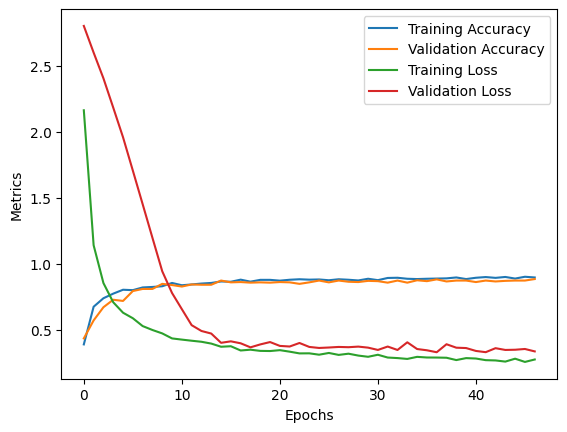

In [ ]:
# Membangun model TensorFlow
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    #tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(y.unique()), activation='softmax')  # Output layer
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callback untuk early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Melatih model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[callback]
)

# Evaluasi model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot akurasi dan loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [ ]:
def predict_crop(temperature, humidity, rainfall):
    # Validasi input terhadap rentang parameter
    if (
        temperature < parameter_ranges.loc['min', 'temperature'] or temperature > parameter_ranges.loc['max', 'temperature'] or
        humidity < parameter_ranges.loc['min', 'humidity'] or humidity > parameter_ranges.loc['max', 'humidity'] or
        rainfall < parameter_ranges.loc['min', 'rainfall'] or rainfall > parameter_ranges.loc['max', 'rainfall']
    ):
        print("Invalid input: Parameters are out of range. Please provide valid values within the dataset's range.")
        return

    # Normalisasi input
    new_data = [[temperature, humidity, rainfall]]
    new_data_normalized = scaler.transform(new_data)
    predictions = model.predict(new_data_normalized)[0]

    # Tentukan rentang probabilitas
    threshold_min = 0.1  # Minimum probabilitas
    threshold_max = 1.0  # Maksimum probabilitas

    # Filter kelas berdasarkan probabilitas
    predictions_tensor = tf.constant(predictions, dtype=tf.float32)
    filtered_indices = tf.where(
        (predictions_tensor >= threshold_min) & (predictions_tensor <= threshold_max)
    )
    filtered_indices = tf.squeeze(filtered_indices).numpy()

    # Pastikan filtered_indices iterable
    if isinstance(filtered_indices, np.int64):
        filtered_indices = [filtered_indices]

    # Tampilkan hasil prediksi
    if len(filtered_indices) > 0:
        filtered_probabilities = [predictions[i] for i in filtered_indices]
        recommended_labels = label_encoder.inverse_transform(filtered_indices)

        # Gabungkan label dan probabilitas untuk diurutkan
        results = sorted(zip(recommended_labels, filtered_probabilities), key=lambda x: x[1], reverse=True)

        # Cetak hasil dengan probabilitas tertinggi di atas
        print("Top Recommendations (Multiple Classes):")
        for i, (label, prob) in enumerate(results):
            print(f"{i + 1}. Crop: {label}, Probability: {prob * 100:.2f}%")
    else:
        print("No recommendations meet the specified probability range.")

# Contoh Prediksi
print("\n=== Prediction Examples ===")
predict_crop(26, 70, 120)
predict_crop(23.849575 , 81.875228,   69.611829)
predict_crop(50, 100, 100)


=== Prediction Examples ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Top Recommendations (Multiple Classes):
1. Crop: kopi, Probability: 74.26%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Top Recommendations (Multiple Classes):
1. Crop: kapas, Probability: 80.92%
2. Crop: anggur, Probability: 18.99%
Invalid input: Parameters are out of range. Please provide valid values within the dataset's range.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [ ]:
save_model_path = "./crops_classification.h5"
model.save(save_model_path)

In [ ]:
!tensorflowjs_converter --input_format keras {save_model_path} ./

/bin/bash: line 1: tensorflowjs_converter: command not found
